The segmentation performance dramatically improved with colorized model, so here is a simplified version of temporal fixing.

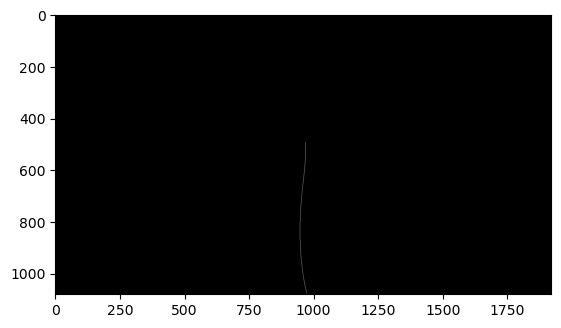

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Should only contain skeletons
image_folder = "Data/Datasets/RigidModelVideo-2-20/2-20-1-clip1/outputs_pruned/segmentation/"

sample_image = cv2.imread(image_folder + "frame0131.jpg", cv2.IMREAD_GRAYSCALE) > 114

plt.imshow(sample_image, cmap='gray')


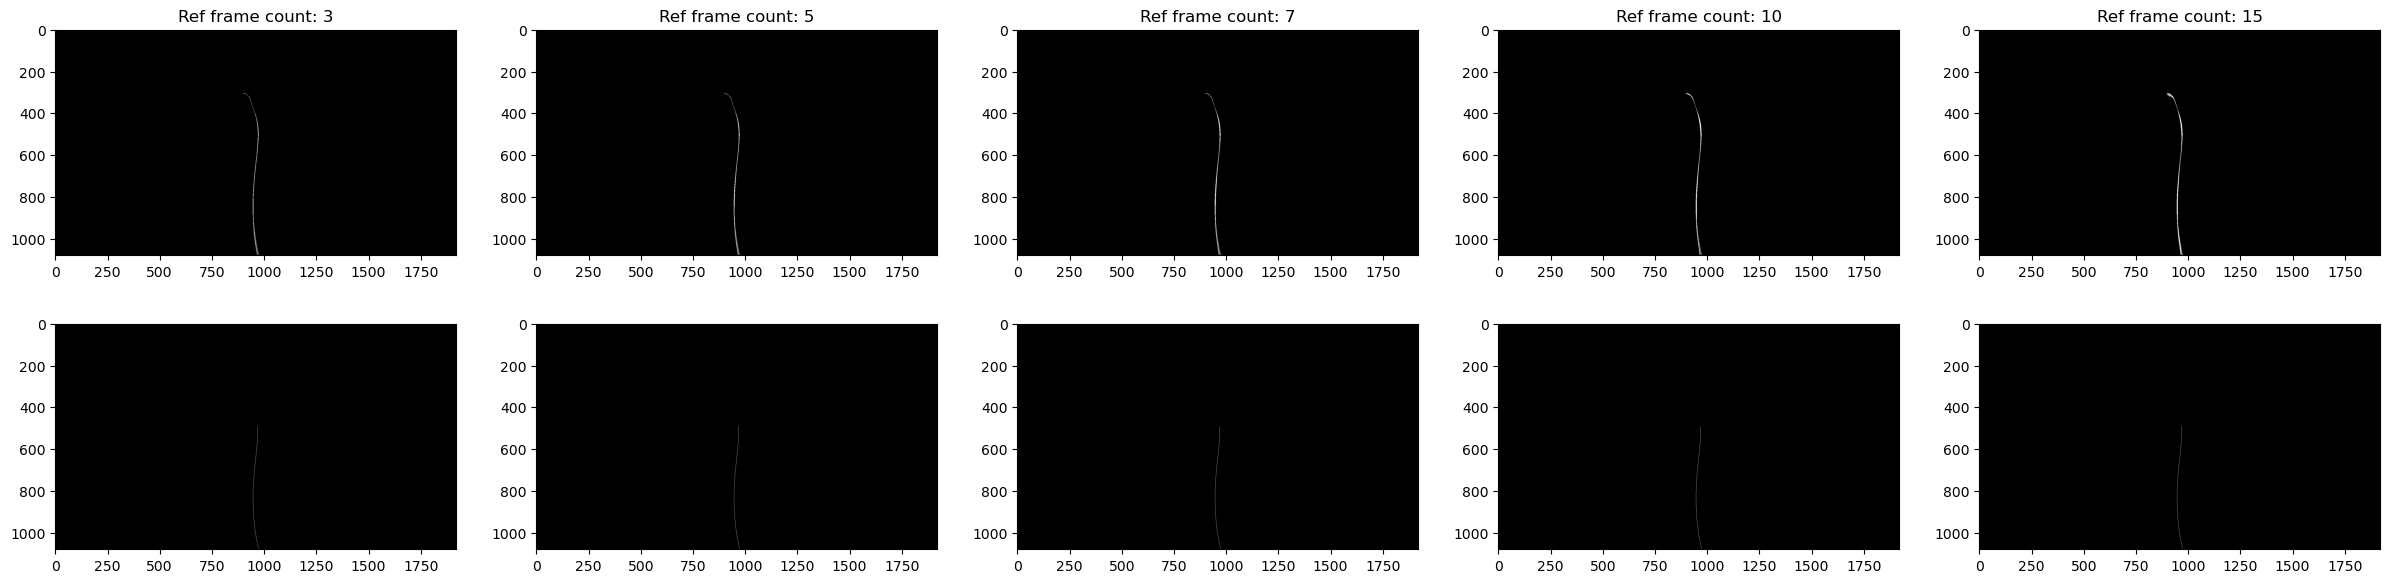

In [9]:
def get_stacked_image(files: list[str]):
    images = np.stack([cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in files], axis=2)
    return images 

def get_stacked_image_from_index(idx, ref_count):
    return get_stacked_image([f"{image_folder}/frame{i:04d}.jpg" for i in range(idx - ref_count, idx + 1)])

def get_stack_sum(idx, ref_count):
    stacked_image = get_stacked_image_from_index(idx-1, ref_count)
    return np.bitwise_or.reduce(stacked_image, axis=2)

def fill_frame_1(index, ref_count):
    ref_sum = get_stack_sum(index, ref_count)
    return np.bitwise_or(ref_sum, cv2.IMREAD_GRAYSCALE)

def show_ref_stack_depth(index):
    target_frame = cv2.imread(f"{image_folder}/frame{index:04d}.jpg", cv2.IMREAD_GRAYSCALE)
    _, axs = plt.subplots(2, 5, figsize=(30, 7))
    for i, r in enumerate([3,5,7,10,15]):
        axs[0][i].imshow(get_stack_sum(index - 1, r), cmap='gray')
        axs[0][i].set_title(f"Ref frame count: {r}")
        axs[1][i].imshow(target_frame, cmap='gray')
    plt.show()

test_naive_method(131)

In [18]:
import os
# output_folder = "Data/Datasets/RigidModelVideo-2-20/2-20-1-clip1/outputs_pruned/segmentation/temporal"
# os.makedirs(output_folder, exist_ok=True)

In [80]:
from tqdm import tqdm

def find_endpoint(binary_image):
    # kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    result = find_connectivity(binary_image)
    return np.argwhere(result == 2)

def find_connectivity(binary_image):
    result = np.zeros_like(binary_image, dtype=np.uint8)
    for [i, j] in np.argwhere(binary_image):
        conn_count = 0
        for ii in range(i-1, i+2):
            for jj in range(j-1, j+2):
                if binary_image[ii, jj]:
                    conn_count += 1
        result[i, j] = conn_count
    return result

def find_search_area(skeleton, endpoints, connectpoint_padding=10, endpoint_padding=40):
    paired = []
    bboxes = []
    if endpoints.shape[0] == 0:
        return []
    for i, ep in enumerate(endpoints):
        if i in paired:
            continue
        distances = [cv2.norm(ep, e) for e in endpoints]
        for idx in np.argsort(distances):
            if idx == i:
                continue
            candidate = endpoints[idx]
            x_min = min(ep[0], candidate[0])
            x_max = max(ep[0], candidate[0])
            y_min = min(ep[1], candidate[1])
            y_max = max(ep[1], candidate[1])
            roi = skeleton[x_min:x_max, y_min:y_max]
            if np.sum(roi) > 1:
                continue    
            else :
                paired.append(i)
                paired.append(idx)
                bboxes.append([
                    x_min - connectpoint_padding, 
                    x_max + connectpoint_padding, 
                    y_min - connectpoint_padding, 
                    y_max + connectpoint_padding
                ])
                break
    left_most_point = endpoints[np.argmin(endpoints[:, 1])]
    bottom_most_point = endpoints[np.argmax(endpoints[:, 0])]
    bboxes.append([
        left_most_point[0] - endpoint_padding, 
        left_most_point[0] + endpoint_padding, 
        left_most_point[1] - endpoint_padding, 
        left_most_point[1]
    ])
    bboxes.append([
        bottom_most_point[0] - endpoint_padding,
        skeleton.shape[0] - 1, 
        bottom_most_point[1] - endpoint_padding, 
        bottom_most_point[1] + endpoint_padding
    ])
    return bboxes
    
output_folder = image_folder + '/filled_4'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

def recursive_fill(skeleton, ref_frame, search_area_padding, endpoint_area_padding, update_thresh):
    endpoints = find_endpoint(skeleton)
    search_areas = find_search_area(skeleton, endpoints, search_area_padding, endpoint_area_padding)
    for bbox in search_areas:
        if len(bbox) == 0:
            continue
        roi_ref = ref_frame[bbox[0]:bbox[1], bbox[2]:bbox[3]]
        roi_cur = skeleton[bbox[0]:bbox[1], bbox[2]:bbox[3]]
        roi_diff = roi_ref.astype(int) - roi_cur

        diff_add = np.count_nonzero(roi_diff > 0)
        diff_sub = np.count_nonzero(roi_diff < 0)
        if (diff_add - diff_sub)  > update_thresh and diff_sub < 500 and diff_add < 1000: # have find something, append it
            search_result = np.bitwise_or.reduce((roi_ref, roi_cur))
            skeleton[bbox[0]:bbox[1], bbox[2]:bbox[3]] = search_result
            print(f"Frame updated at bbox {bbox}")
            return recursive_fill(skeleton, ref_frame, search_area_padding, endpoint_area_padding, update_thresh)
    return skeleton

def temporal_fill_process_4(foi, ref_count=5, search_area_padding = 10, endpoint_area_padding=40, update_thresh = 20, length_diff_limit=100):
    d = []
    ref_stack = np.zeros((1080, 1920, ref_count), dtype=np.uint8)
    for i in tqdm(foi):
        current_frame = cv2.imread(f"{image_folder}/frame{i:04d}.jpg", cv2.IMREAD_GRAYSCALE)
        skeleton = current_frame > 40 # get clean segmentation if using jpeg
        endpoints = find_endpoint(skeleton)
        search_areas = find_search_area(skeleton, endpoints, search_area_padding, endpoint_area_padding)
        current_frame = skeleton
        if i >= foi[0] + ref_count: 
            for r in range(ref_count):
                ref_frame = ref_stack[:, :, -r]
                d.append([np.count_nonzero(ref_frame), np.count_nonzero(current_frame)])
                if np.count_nonzero(ref_frame) - np.count_nonzero(current_frame) > length_diff_limit:
                    print(f"begin patching from ref {r} of image {i}")
                    current_frame = recursive_fill(current_frame, ref_frame, search_area_padding, endpoint_area_padding, update_thresh)
        ref_stack = np.roll(ref_stack, shift=-1, axis=2)
        ref_stack[:, :, -1] = current_frame
        cv2.imwrite(f"{output_folder}/frame{i:04d}.jpg", current_frame.astype(np.uint8) * 255)
    d = np.array(d)
    # plt.plot(d[:, 0], label='Add')
    # plt.plot(d[:, 1], label='Sub')
    plt.plot(d[:, 0] - d[:, 1], label='Total')
    plt.legend() 
     

 75%|███████▌  | 15/20 [00:00<00:00, 27.86it/s]

begin patching from ref 0 of image 131
Frame updated at bbox [394, 594, 870, 970]
Frame updated at bbox [450, 504, 959, 980]
Frame updated at bbox [294, 494, 854, 954]


100%|██████████| 20/20 [00:00<00:00, 28.54it/s]


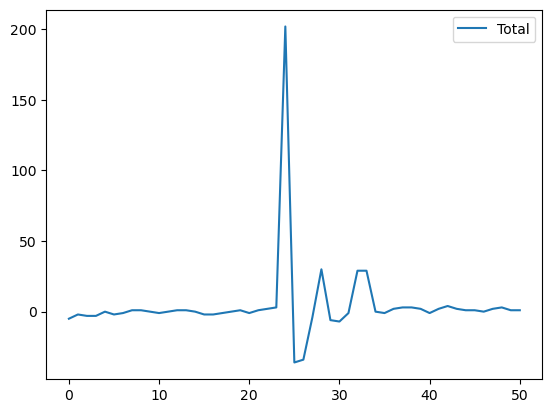

In [81]:
temporal_fill_process_4(range(1, 140), ref_count=3, endpoint_area_padding=100, update_thresh=10, length_diff_limit=100) 